In [41]:
import os, sys
from scipy.integrate import solve_ivp

In [42]:
import numpy as np
from tqdm import tqdm

In [43]:
import matplotlib.pyplot as plt

In [44]:
cwd = os.getcwd()
cwd_ujoin = cwd.split("\\")[:-2]
basedir = "\\".join(cwd_ujoin)
sys.path.append(basedir)

In [45]:
from attitude.rigid_body import attitude_rate
from attitude.parameters import quat2dcm, dcm2quat

In [46]:
from attitude import x_tilde

### Tracking

In [47]:
def lyapunov(w_br, I):
    return 0.5*w_br.T@I@w_br

In [48]:
def control(w, w_r, w_r_dot, I, P):
    w_tilde = x_tilde(w)
    return w_tilde@I@w - I@w_tilde@w_r + I@w_r_dot - P@(w - w_r)

In [49]:
def xdot(x, u, I, **params):
    qdot, wdot = attitude_rate(x[:4], x[4:], u, I)
    return np.hstack((qdot, wdot))

In [50]:
def predict(x, u, I, start, end, **solver_opts):
    fx = lambda t, y: xdot(y, u, I)
    sol = solve_ivp(fx, [start, end], x, rtol = 1e-5, **solver_opts)
    return sol.y.flatten()

Regulation

In [51]:
q0 = np.array([1, 0, 0, 0])
w0 = np.deg2rad(np.array([0.0, 0.0, 0.0]))
x0 = np.hstack((q0, w0))
u0 = np.array([0.0, 0.0, 0.0])

In [52]:
qt = np.array([0, 0, 0, 1])
wt = np.deg2rad(np.array([0.0, 0.0, 0.0]))
xt = np.hstack((qt, wt))
wt_dot = np.deg2rad(np.array([0.0, 0.0, 0.0]))

In [53]:
t_start = 0
t_end = 180
dt = 0.5
t_vec = np.arange(t_start, t_end + dt, dt)

In [54]:
I = np.diag([10.0, 10.0, 100.0])

In [55]:
BN = quat2dcm(q0)
TN = quat2dcm(qt)
qr0 = dcm2quat(BN@TN.T)

In [56]:
x = x0
u = u0
qr = qr0
x_history = np.zeros((len(t_vec), len(x)))
u_history = np.zeros((len(t_vec), len(u)))
solver_opts = dict(t_eval=[0])
Kq = 0.5
K = np.array([
    [0.5,  0,  0],
    [0, 0.5, 0],
    [0, 0,  10]
])
errp = 0
errn = errp
err_total = 0

for idx, t in enumerate(t_vec):
    uq = -Kq*qr[1:]
    uw = control(x[4:], wt, wt_dot, I, K)
    u = uq + uw
    x_history[idx, :] = x
    u_history[idx, :] = u
    start = t
    end = t + dt
    solver_opts['t_eval'] = [end]
    xnew = predict(x, u, I, start, end, **solver_opts)
    x = xnew
    BN = quat2dcm(x[:4])
    TN = quat2dcm(qt)
    qr = dcm2quat(BN@TN.T)


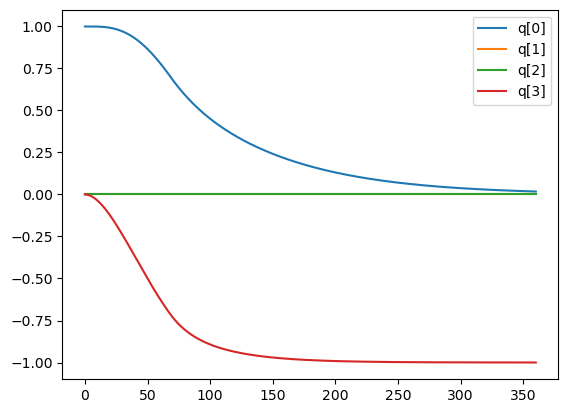

In [57]:
plt.plot(x_history[:, :4])
plt.legend(['q[0]', 'q[1]', 'q[2]', 'q[3]'])

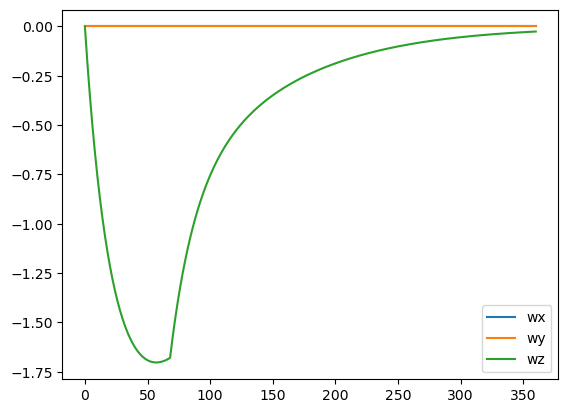

In [58]:
plt.plot(np.rad2deg(x_history[:, 4:]))
plt.legend(['wx', 'wy', 'wz'])

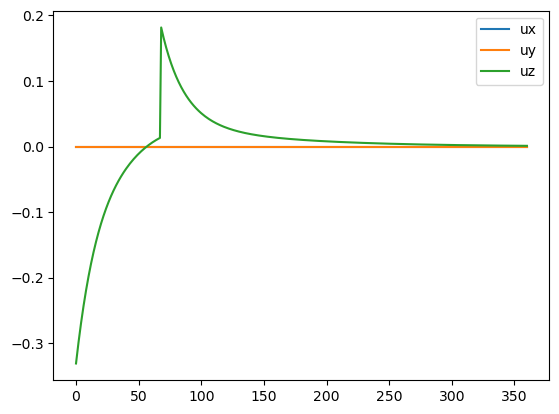

In [59]:
plt.plot(u_history)
plt.legend(['ux', 'uy', 'uz'])